In [1]:
# General imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import experimentdataanalysis.analysis.dataframe_plotting as dfplot
import experimentdataanalysis.data_io.csv_to_dataframe as csv2df

In [2]:
# import jtplot submodule from jupyterthemes IF installed
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=1.6)
    # set the default figure size
    jtplot.figsize(x=6., y=6.)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

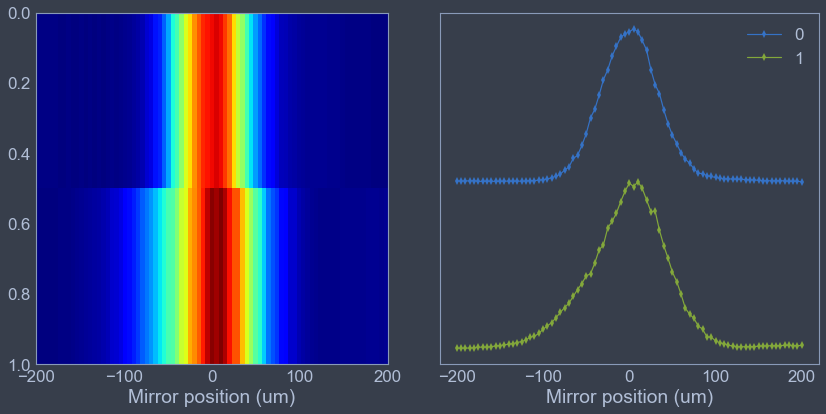

mirror_position   lockin1  lockin2  file_index  \
run_id index_2d index_1d                                                   
0      11.0     0                  -200.0  0.001661  0.00574           0   
                1                  -195.0  0.001721  0.00530           0   
                2                  -190.0  0.001697  0.00582           0   
                3                  -185.0  0.001571  0.00600           0   
                4                  -180.0  0.001674  0.00658           0   

                          wavelength  
run_id index_2d index_1d              
0      11.0     0              836.0  
                1              836.0  
                2              836.0  
                3              836.0  
                4              836.0

In [3]:
# UNITS: 
# time: ps
# b-field: mT
# voltages: V

# REQUIRED: directory containing 2D scans
# parent_dir = ('C:\\Data\\feb2017_data_part2')
parent_dir = ('C:\\Data\\FitTrialData2\\Mirror_Scan')

# REQUIRED: data storage format information
delimiter = '\t'
trailing_delimiters = False  # rows end in delimiters
num_headerlines = 0
column_names_row = 1  # NOT counting skipped lines from num_headerlines
overwriting_column_names = []

if not overwriting_column_names:
    overwriting_column_names = None
pandas_read_csv_kwargs = {
     'skiprows': num_headerlines,
     'header': column_names_row,
     'names': overwriting_column_names,
     'delimiter': delimiter,
}
if trailing_delimiters:  # needed to avoid problems
    pandas_read_csv_kwargs['index_col'] = False

# REQUIRED: filename key for data files, will load only these
filename_key = '.dat'

# REQUIRED: criteria for grouping runs
run_criteria = 'directory'

# OPTIONAL: filepath parsing rules
# DEFAULT SEARCH TERMS AND SEARCH RULES:
# 1. If first string found, register second string as
#    tag containing third string/value
#        e.g. if keyword_list contains ("warmup", "Warmup?", "Yes"):
#             "...warmup..." -> {"Warmup?": "Yes"}
this_element_keyword_list = [
    (       "CISP", "Experiment Type", "CISP"       ),
    ( "Delay_Scan", "Experiment Type", "Delay_Scan" ),
    ( "Field_Scan", "Experiment Type", "Field_Scan" ),
    ("Mirror_Scan", "Experiment Type", "Mirror_Scan"),
    ( "RMBE1130-K", "Sample ID", "RMBE1130-K"),
    ("[1-10]Horiz", "Sample Orientation", "[1-10]Horiz"),
]
# 2. Grab next element(s) if this one CONTAINS first string,
#    tag next element(s) as second string(s)
#        e.g. "..._Ind_3_..." -> {"FastScanIndex": 3}
#        e.g. "..._2Dscan_MirrorY_MirrorZ_..."
#                 -> {"SecondScanType": "MirrorY",
#                     "FirstScanType": "MirrorZ"}
next_element_keyword_list = []
# 3. Grab this element if it CONTAINS first string,
#    tag remainder as second string
#        e.g. "..._30K_..." -> {"SetTemperature": 30}
in_this_element_keyword_list = [
    ("FIELD", "Date_and_Scan_2D_Index"),
    ("DLAY", "Date_and_Scan_2D_Index"),
    ("STPR", "Date_and_Scan_2D_Index"),
    ("phi-", "Electric Field Angle"),
    ("T", "Magnetic Field (T)"),
    ("K", "Set Temperature (K)"),
    ("nm", "Wavelength (nm)"),
    ("ps", "Delay Time (ps)"),
    ("V", "Voltage (V)"),
]
parsing_keyword_lists = [this_element_keyword_list,
                         next_element_keyword_list,
                         in_this_element_keyword_list]

# OPTIONAL: metadata processing functions,
# must accept dict and modify in-place
def derive_metadata_from_scan_type_tag(metadata_dict):
    if 'Date_and_Scan_2D_Index' in metadata_dict.keys():
        date_and_index = str(metadata_dict['Date_and_Scan_2D_Index'])
        metadata_dict['Date'] = date_and_index[:6]
        metadata_dict['Scan_2D_Index'] = float(date_and_index[6:]) - 1
        del metadata_dict['Date_and_Scan_2D_Index']
# def consolidate_aliases_for_bfield(metadata_dict):
#     if 'Magnetic Field (T)' in metadata_dict.keys():
#          metadata_dict['Magnetic Field (mT)'] = \
#              1000.0 * metadata_dict['Magnetic Field (T)']
metadata_processing_fcns = [derive_metadata_from_scan_type_tag]

# OPTIONAL: metadata-based filtering fcns, type: dict() -> bool
# fcns returning False if data should be ignored
metadata_filter_fcns = [
#     lambda metadata_dict: metadata_dict.get("# repeats", 1) <= 2,
    lambda metadata_dict: "alignment" not in metadata_dict.get("Filepath"),
    lambda metadata_dict: "Scan_2D_Index" in metadata_dict.keys(),
]

# OPTIONAL: metadata tags to be converted to dataframe columns.
# Elements should be of form ('metadata tag', 'column name')
metadata_tag_to_column_list = [
    (             'Run ID', 'run_id'),
    (      'Scan_2D_Index', 'index_2d'),
    ('Mirror Position (um)', 'mirror_position'),
    ('Magnetic Field (T)', 'b_external'),
    (    'Wavelength (nm)', 'wavelength'),
]

# OPTIONAL: dataframe processing functions,
# must accept dataframe and modify in-place
def set_dataframe_indices(df):
    df['index_1d'] = df.index  # assumes index = 0,1,2,...  
    df.set_index(['run_id', 'index_2d', 'index_1d'],
                 drop=True, append=False, inplace=True)
def edit_dataframe_colnames(df):
    renaming_dict = {}
    if 'Mirror Position (um)' in list(df):
        renaming_dict['Mirror Position (um)'] = 'mirror_position'
    if 'Lock-In 1 (V)' in list(df):
        renaming_dict['Lock-In 1 (V)'] = 'lockin1'
    if 'Lock-In 2 (V)' in list(df):
        renaming_dict['Lock-In 2 (V)'] = 'lockin2'
    df.rename(columns=renaming_dict, inplace=True)
dataframe_processing_fcns = [
    set_dataframe_indices,
    edit_dataframe_colnames,
]

filepath_list, file_dataframes_list, file_metadata_list = \
    csv2df.process_directory_csvs_to_dataframes(
        parent_dir, filename_key, run_criteria,
        pandas_read_csv_kwargs,
        parsing_keyword_lists,
        metadata_processing_fcns,
        metadata_filter_fcns,
        metadata_tag_to_column_list,
        dataframe_processing_fcns)

full_dataframe = pd.concat(file_dataframes_list)
full_dataframe.sort_index(ascending=True, inplace=True)

# plot newly created dataframe and show the first few rows
figure_size = (12, 6)
num_waterfall_plots = 4
data_column = 'lockin2'
x_values_column = 'mirror_position'
y_values_column = None
xlabel = 'Mirror position (um)'
ylabel = None
imshow_kwargs = {'aspect': 1.0,
                 'origin': 'upper'}
plt.figure(figsize=figure_size)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
dfplot.plot_dataframe_colorplot(full_dataframe, data_column,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=ylabel,
                                ax=ax1, **imshow_kwargs)
dfplot.plot_dataframe_waterfall(full_dataframe, data_column,
                                num_waterfall_plots,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=None, ax=ax2)
ax2.yaxis.set_ticklabels([])
plt.show()
full_dataframe.head(5)